In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)

In [2]:
# Read data
df = pd.read_csv('dataset_phishing.csv')

In [3]:
# Summary statistics
df.describe(include="all")

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430
unique,11429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,http://e710z0ear.du.r.appspot.com/c:/users/use...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,legitimate
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5715
mean,NaN,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,...,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,NaN
std,NaN,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,...,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,NaN
min,NaN,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000,NaN
25%,NaN,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000,NaN
50%,NaN,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000,NaN
75%,NaN,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000,NaN


In [4]:
# Finding columns with missing values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [5]:
# Removing variables with low variance (10%)
X = df.drop(columns=['url', 'status'])
sel = VarianceThreshold(threshold=(0.1 * (1 - 0.1)))
X_var_filtered = sel.fit_transform(X)
mask = sel.get_support()
X_filtered = X.loc[:, mask]

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)
X_scaled = pd.DataFrame(scaler.fit_transform(X_scaled), columns=X_filtered.columns)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

                       Feature         VIF
0                   length_url   10.788749
1              length_hostname    3.309528
2                           ip    1.740619
3                      nb_dots    6.514300
4                   nb_hyphens    8.058767
5                        nb_qm    3.390262
6                       nb_and   11.044439
7                        nb_eq   12.774681
8                nb_underscore    3.291856
9                   nb_percent    4.490960
10                    nb_slash    6.815871
11               nb_semicolumn    1.769946
12                    nb_space    1.123991
13                      nb_www    1.977555
14                      nb_com    1.362610
15                 https_token    1.320002
16               nb_subdomains    2.460339
17               prefix_suffix    1.385316
18          shortening_service    1.312023
19              nb_redirection    1.255219
20            length_words_raw   52.317148
21                 char_repeat    1.639309
22         

In [7]:
# Function to calculate VIF and remove features with VIF > threshold
def calculate_vif(df, thresh=5):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    while vif_data['VIF'].max() > thresh:
        # Find the feature with the highest VIF
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
        
        print(f"Removing feature '{max_vif_feature}' with VIF: {vif_data['VIF'].max()}")
        
        # Drop the feature with the highest VIF from the dataset
        df = df.drop(columns=[max_vif_feature])
        
        # Recalculate VIF for the remaining features
        vif_data = pd.DataFrame()
        vif_data['Feature'] = df.columns
        vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        
    print("Final VIF values:")
    print(vif_data)
    return df

# Calculate VIF and remove columns with VIF > 5
X_scaled = calculate_vif(X_scaled, thresh=5)

Removing feature 'longest_word_path' with VIF: 102.79661121229837
Removing feature 'length_words_raw' with VIF: 52.16083930066773
Removing feature 'avg_word_host' with VIF: 44.19574418460644
Removing feature 'avg_words_raw' with VIF: 15.991655261920124
Removing feature 'nb_eq' with VIF: 12.345204479984567
Removing feature 'length_url' with VIF: 9.49437241810535
Removing feature 'ratio_intHyperlinks' with VIF: 6.2501734775510025
Final VIF values:
                       Feature       VIF
0              length_hostname  3.078001
1                           ip  1.582907
2                      nb_dots  2.976449
3                   nb_hyphens  1.252799
4                        nb_qm  1.760078
5                       nb_and  2.816446
6                nb_underscore  1.385276
7                   nb_percent  1.143398
8                     nb_slash  1.925841
9                nb_semicolumn  1.703553
10                    nb_space  1.116249
11                      nb_www  1.915923
12               

In [8]:
# Calculate z-scores and identify outliers
from scipy import stats

z_scores = np.abs(stats.zscore(X_filtered))
X_outliers = X_filtered[(z_scores > 3).any(axis=1)]

X_outliers

#NEED TO REMOVE OUTLIERS???????????????????????????????????????????????????????????????????????????????????????????????????????
# Removing outliers based on z-scores
# X_filtered = X_filtered[(z_scores < 3).all(axis=1)]
# y_no_outliers = y[(z_scores < 3).all(axis=1)]

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_qm,nb_and,nb_eq,nb_underscore,nb_percent,...,ratio_extMedia,safe_anchor,empty_title,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,web_traffic,google_index,page_rank
1,77,23,1,1,0,0,0,0,0,0,...,20.000000,100.000000,0,1,0,77,5767,0,1,2
6,19,12,0,2,0,0,0,0,0,0,...,100.000000,100.000000,0,0,1,170,7529,0,0,1
9,104,10,0,1,10,0,0,0,0,0,...,90.000000,58.139535,0,1,0,128,9368,6774,0,5
12,83,14,0,1,9,0,0,0,0,0,...,1.550388,38.793103,0,1,1,320,1505,158942,0,4
16,31,22,0,2,0,0,0,0,0,0,...,0.000000,76.190476,0,1,1,3069,8301,99386,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11421,117,26,0,2,1,0,0,0,1,0,...,0.000000,20.000000,0,1,0,134,2058,0,1,2
11422,25,17,0,1,0,0,0,0,0,0,...,0.000000,100.000000,0,0,0,144,2778,788648,0,2
11423,85,15,0,4,0,1,0,3,0,0,...,0.000000,100.000000,0,0,1,293,5186,10408014,1,1
11424,62,15,0,2,0,0,0,0,6,0,...,0.000000,20.000000,0,0,1,506,8829,2635,1,6


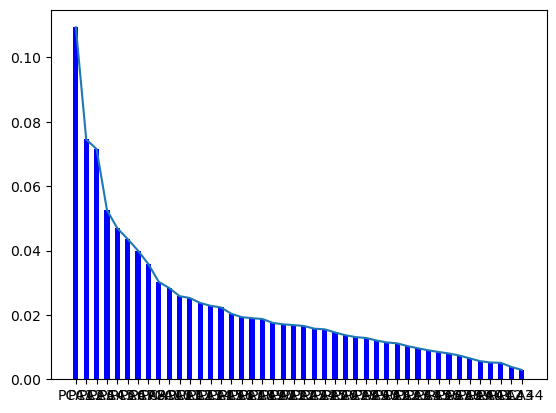

In [9]:
# =============================== PCA to identify the number of features ==========================================
from sklearn.decomposition import PCA

le = LabelEncoder()
y = le.fit_transform(df["status"])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

pca = PCA(n_components=44)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)

x_names =[]
y= pca.explained_variance_ratio_

for i in range(len(y)):
    x_names.append('PCA'+str(i+1))

default_x_ticks = range(len(x_names))

plt.plot(default_x_ticks, y)
plt.bar(default_x_ticks, y,width=0.5,color= 'blue')
plt.xticks(default_x_ticks, x_names)
plt.show()

In [10]:
sum = 0
num_features = 0
for v in pca.explained_variance_ratio_:
    sum += v
    num_features += 1
    if sum >= 0.85:
        break
print("Number of features to choose:", num_features)

Number of features to choose: 27


In [11]:
# =============================== Random Forest ==========================================
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
importances = rf_model.feature_importances_
feature_names = X_scaled.columns
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

reduced_df_rf = feature_importance_df_rf.head(num_features)

In [12]:
# Make predictions on the test set using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Print the evaluation metrics for Random Forest
print(f"\nRandom Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - F1 Score: {f1_rf:.4f}")
print(f"Random Forest - ROC AUC: {roc_auc_rf:.4f}")

# Print the classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Print the confusion matrix for Random Forest
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest - Accuracy: 0.9641
Random Forest - Precision: 0.9641
Random Forest - Recall: 0.9641
Random Forest - F1 Score: 0.9641
Random Forest - ROC AUC: 0.9944

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1732
           1       0.96      0.96      0.96      1697

    accuracy                           0.96      3429
   macro avg       0.96      0.96      0.96      3429
weighted avg       0.96      0.96      0.96      3429


Random Forest Confusion Matrix:
[[1672   60]
 [  63 1634]]


In [13]:
# =============================== Lasso Regression ======================================
lasso_model = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, random_state=42)
lasso_model.fit(X_train, y_train)

# Get coefficients and feature importance
coefs = lasso_model.coef_
feature_importance_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

# Sort by the absolute value of coefficients to get the most important features
feature_importance_df_lr['Abs_Coefficient'] = feature_importance_df_lr['Coefficient'].abs()

# Show the top 27 important features based on the magnitude of the coefficients
reduced_df_lr = feature_importance_df_lr.sort_values(by='Abs_Coefficient', ascending=False).head(num_features)

# Drop the temporary Abs_Coefficient column
reduced_df_lr = reduced_df_lr.drop(columns=['Abs_Coefficient'])

# Make predictions on the test set using Lasso
y_pred = (lasso_model.predict(X_test) > 0.5).astype(int)


In [14]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, lasso_model.predict(X_test))

# Print the evaluation metrics
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9288
Precision: 0.9289
Recall: 0.9288
F1 Score: 0.9288
ROC AUC: 0.9785

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1732
           1       0.92      0.93      0.93      1697

    accuracy                           0.93      3429
   macro avg       0.93      0.93      0.93      3429
weighted avg       0.93      0.93      0.93      3429


Confusion Matrix:
[[1599  133]
 [ 111 1586]]


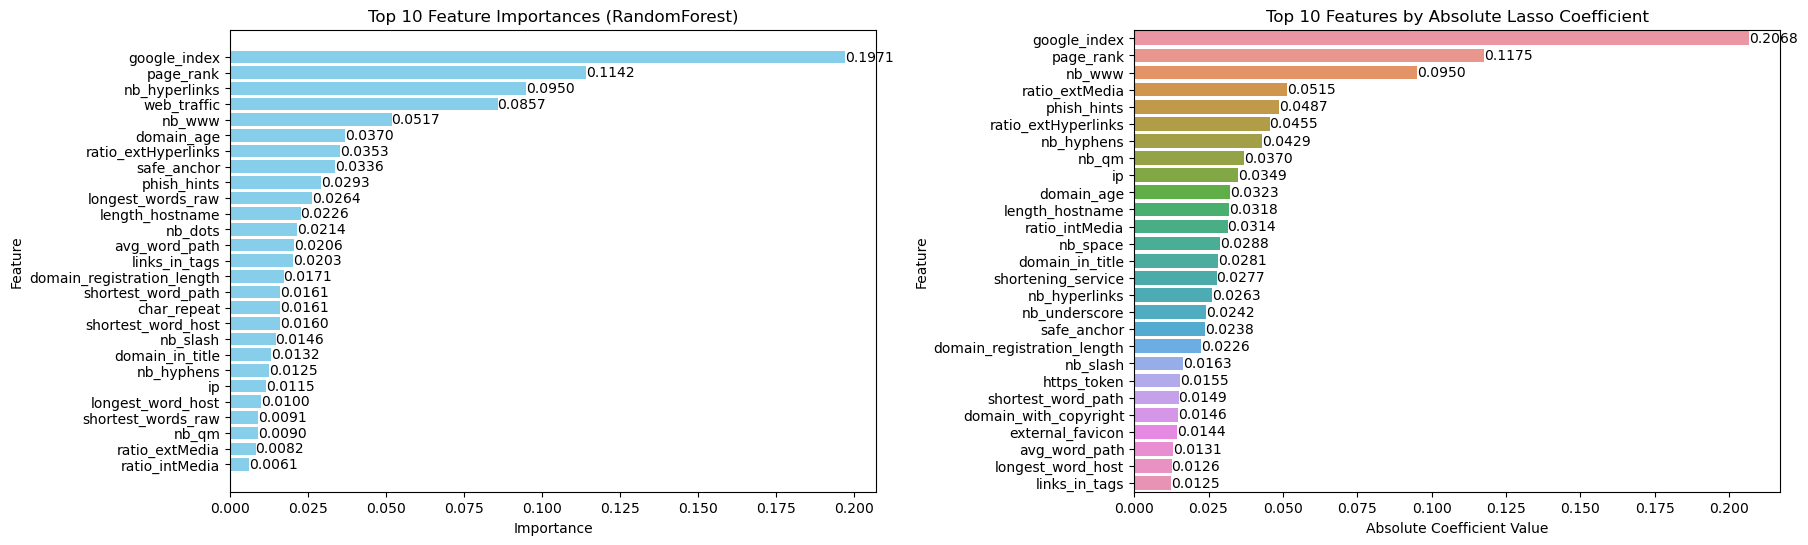

In [15]:
# ============================== Plotting side by side =============================
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# RandomForest feature importances plot
axes[0].barh(reduced_df_rf['Feature'][::-1], reduced_df_rf['Importance'][::-1], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')
axes[0].set_title('Top 10 Feature Importances (RandomForest)')
for index, value in enumerate(reduced_df_rf['Importance'][::-1]):
    axes[0].text(value, index, f'{value:.4f}', va='center')

# Lasso coefficients plot (show absolute values)
reduced_df_lr['Abs_Coefficient'] = reduced_df_lr['Coefficient'].abs()  # Calculate absolute values for Lasso

# Plotting the absolute coefficients
sns.barplot(x='Abs_Coefficient', y='Feature', data=reduced_df_lr, ax=axes[1], order=reduced_df_lr['Feature'])
axes[1].set_title('Top 10 Features by Absolute Lasso Coefficient')
axes[1].set_xlabel('Absolute Coefficient Value')
axes[1].set_ylabel('Feature')

# Annotate the bars with the absolute coefficient values
for index, value in enumerate(reduced_df_lr['Abs_Coefficient']):
    axes[1].text(value, index, f'{value:.4f}', ha='left', va='center')

# Adjust spacing between the plots
plt.subplots_adjust(wspace=0.4)  # Increase the width space between the subplots

plt.show()

In [16]:
# Get the top 27 features from Random Forest and Lasso
top_rf_features = set(reduced_df_rf['Feature'].head(27))  # Random Forest top 27 features
top_lasso_features = set(reduced_df_lr['Feature'].head(27))  # Lasso top 27 features

# Find the intersection of the top 27 features
common_features = top_rf_features.intersection(top_lasso_features)

# Convert the intersection set to a list (for further use, if needed)
common_features = list(common_features)

# Display the common features
print("Common Features between Random Forest and Lasso:")
print(common_features)

Common Features between Random Forest and Lasso:
['nb_qm', 'domain_age', 'longest_word_host', 'ratio_extHyperlinks', 'nb_slash', 'phish_hints', 'nb_www', 'ratio_extMedia', 'length_hostname', 'page_rank', 'avg_word_path', 'nb_hyphens', 'ratio_intMedia', 'links_in_tags', 'domain_in_title', 'google_index', 'safe_anchor', 'nb_hyperlinks', 'ip', 'domain_registration_length', 'shortest_word_path']


In [17]:
# Common features
common_features = top_rf_features.intersection(top_lasso_features)
print("Common Features:", common_features)

# Unique to set 1
unique_top_rf_features = top_rf_features.difference(top_lasso_features)
print("\nUnique to top_rf_features:", unique_top_rf_features)

# Unique to set 2
unique_top_lasso_features = top_lasso_features.difference(top_rf_features)
print("\nUnique to top_lasso_features:", unique_top_lasso_features)

Common Features: {'nb_qm', 'domain_age', 'longest_word_host', 'ratio_extHyperlinks', 'nb_slash', 'phish_hints', 'nb_www', 'ratio_extMedia', 'length_hostname', 'page_rank', 'avg_word_path', 'nb_hyphens', 'ratio_intMedia', 'links_in_tags', 'domain_in_title', 'google_index', 'safe_anchor', 'nb_hyperlinks', 'ip', 'domain_registration_length', 'shortest_word_path'}

Unique to top_rf_features: {'nb_dots', 'char_repeat', 'longest_words_raw', 'shortest_word_host', 'shortest_words_raw', 'web_traffic'}

Unique to top_lasso_features: {'nb_underscore', 'https_token', 'nb_space', 'external_favicon', 'domain_with_copyright', 'shortening_service'}


In [18]:
common_features.update(["web_traffic", "longest_words_raw", "nb_dots", "nb_space", "shortening_service", "nb_underscore"])

In [19]:
common_features

{'avg_word_path',
 'domain_age',
 'domain_in_title',
 'domain_registration_length',
 'google_index',
 'ip',
 'length_hostname',
 'links_in_tags',
 'longest_word_host',
 'longest_words_raw',
 'nb_dots',
 'nb_hyperlinks',
 'nb_hyphens',
 'nb_qm',
 'nb_slash',
 'nb_space',
 'nb_underscore',
 'nb_www',
 'page_rank',
 'phish_hints',
 'ratio_extHyperlinks',
 'ratio_extMedia',
 'ratio_intMedia',
 'safe_anchor',
 'shortening_service',
 'shortest_word_path',
 'web_traffic'}

In [20]:
X = df[list(common_features)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y = le.fit_transform(df["status"])

# Step 1: Split data into 70% train and 30% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Split the temp set into 50% validation and 50% test (15% each of the original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)